# PDS A2
You will be shared ten files from coders who annotated verses from the 1st book of Iliad (no names shared). In each file there are the following columns: polarity (the sentiment the reader felt while reading the verse), emotions, hero (Homer narrating or a hero talking). The goal of this assignment is to build Machine Learning for automated sentiment annotation.  

---

### 1. Exploring the data.
  * Address the missing values (and any outliers). 
  * Measure inter-annotator agreement in the *polarity* and *hero* columns.

---

# T1
At first, the path is given using dot instead of hard path. The xlsx files within the folder are turned into a data frame. By using the line of code [f for f in files if f[-4:] == 'xlsx'] an accidental read of a non xlsx file in the future is prevented (The reference shows the inspiration for this method). While reading through the files and making a data frame out of them, a column called ID is added in order to know which annotator each annotation belongs to. Four unwanted unnamed calumns appeared in the data set. By examining them, it was found that 3 of them contained no data so they were dropped. The column 'Unnamed: 4' on the other hand had a few data within it containing heros. By using np.where, as shown in the reference, the hero column was given all the data contained in Unnamed: 4 wherever the hero column had no value and the Unnamed column had. After that, the last Unnamed column was dropped. By going through the hero column, it is shown that each annotator has written some of the heroes by using a different name. This is why the correct name of each hero was found and the wrong names were replaced with the correct ones. After that, the missing values were addressed. The missing values for the hero column was filled with the narrator's name -Homer- and the polarities and emotions were filled with no emotions and neutral respectively. This was done by taking into account that each annotator left the hero column blank when the narrator was speaking and the polarity and emotion columns when they had not sentiment or emotion. After the data were cleaned properly, a list of combinations for each annotator with one another was created using the combinations module from the itertools library as shown in the reference next to the code. Using that list, the kappa cohen was calculated as well as the annotator's agreement. One can easily see that the annotators do not agree much on the polarities as only 40% of the time the annotators have the same values given as polarity. On the other hand more than 70% of the annotators agree as far as the heroes go but that can be attributed to the fact that more than 1700 values were missing from the heroes column and they were filled with the narrator.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import string
import requests
import re
from sklearn.metrics import cohen_kappa_score as kappa
from itertools import combinations as com
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import svm
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from bs4 import BeautifulSoup

In [4]:
warnings.filterwarnings("ignore") # Filter Warnings since it keeps giving warnings when dropping columns
path= r'C:.\IB1-annotated'
files = os.listdir(path) # Get the files from the path

In [5]:
filenames = [f for f in files if f[-4:] == 'xlsx'] # Choose only excel files. reference: https://stackoverflow.com/questions/56423421/read-all-xlsx-files-in-a-folder-and-save-the-files-in-different-dataframes answer by PirateNinjas
print(filenames)
os.chdir(path) # Change Directory so that it can read the excel files.
coders = pd.DataFrame() # Initiate the Data Frame
for f in filenames:
    df = pd.read_excel(f, sheet_name='annotation') #Make sure to read from the annotation sheet.
    df['ID'] = int(f[0:-5])
    coders = coders.append(df) # Create the Data Frame
coders

['3150014.xlsx', '3252107.xlsx', '3252108.xlsx', '3252113.xlsx', '335201.xlsx', '3352106.xlsx', '3352114.xlsx', '3352115.xlsx', '3352116.xlsx', '3352119.xlsx']


,verse,polarity,emotions,hero,ID,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"Τη μάνητα, θεά, τραγούδα μας του ξακουστού Αχι...",positive,admiration,NaN,3150014,NaN,NaN,NaN,NaN
1,"ανάθεμα τη, πίκρες που 'δωκε στους Αχαιούς περ...",negative,pain,NaN,3150014,NaN,NaN,NaN,NaN
2,και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...,negative,awe,NaN,3150014,NaN,NaN,NaN,NaN
3,"παλικαριών, στους σκύλους ρίχνοντας να φάνε τα...",negative,fear,NaN,3150014,NaN,NaN,NaN,NaN
4,και στα όρνια ολούθε —έτσι το θέλησε να γίνει ...,no emotion,acknowledgement,NaN,3150014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
584,κει που 'χε χτίσει στον καθένα τους παλάτι ο κ...,positive,joy,NaN,3352119,NaN,NaN,NaN,NaN
585,"ο ξακουστός τεχνίτης Ήφαιστος, με τη σοφή του ...",positive,respect,NaN,3352119,NaN,NaN,NaN,NaN
586,"Κι ο Δίας ο Ολύμπιος, ό αστραπόχαρος, στην κλί...",positive,respect,NaN,3352119,NaN,NaN,NaN,NaN
587,"εκεί που ως τώρα πάντα, ως του 'ρχονταν ύπνος ...",positive,joy,NaN,3352119,NaN,NaN,NaN,NaN


In [6]:
coders

,verse,polarity,emotions,hero,ID,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"Τη μάνητα, θεά, τραγούδα μας του ξακουστού Αχι...",positive,admiration,NaN,3150014,NaN,NaN,NaN,NaN
1,"ανάθεμα τη, πίκρες που 'δωκε στους Αχαιούς περ...",negative,pain,NaN,3150014,NaN,NaN,NaN,NaN
2,και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...,negative,awe,NaN,3150014,NaN,NaN,NaN,NaN
3,"παλικαριών, στους σκύλους ρίχνοντας να φάνε τα...",negative,fear,NaN,3150014,NaN,NaN,NaN,NaN
4,και στα όρνια ολούθε —έτσι το θέλησε να γίνει ...,no emotion,acknowledgement,NaN,3150014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
584,κει που 'χε χτίσει στον καθένα τους παλάτι ο κ...,positive,joy,NaN,3352119,NaN,NaN,NaN,NaN
585,"ο ξακουστός τεχνίτης Ήφαιστος, με τη σοφή του ...",positive,respect,NaN,3352119,NaN,NaN,NaN,NaN
586,"Κι ο Δίας ο Ολύμπιος, ό αστραπόχαρος, στην κλί...",positive,respect,NaN,3352119,NaN,NaN,NaN,NaN
587,"εκεί που ως τώρα πάντα, ως του 'ρχονταν ύπνος ...",positive,joy,NaN,3352119,NaN,NaN,NaN,NaN


In [7]:
print(coders['Unnamed: 4'].unique(), coders['Unnamed: 5'].unique(), coders['Unnamed: 6'].unique(), coders['Unnamed: 7'].unique())

[nan 'CHRISIS' 'Kalhas' 'Hrisis' 'Muse' 'Calchas'] [nan] [nan] [nan]


In [8]:
coders.drop(['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'], axis=1, inplace=True)
coders

,verse,polarity,emotions,hero,ID,Unnamed: 4
0,"Τη μάνητα, θεά, τραγούδα μας του ξακουστού Αχι...",positive,admiration,NaN,3150014,NaN
1,"ανάθεμα τη, πίκρες που 'δωκε στους Αχαιούς περ...",negative,pain,NaN,3150014,NaN
2,και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...,negative,awe,NaN,3150014,NaN
3,"παλικαριών, στους σκύλους ρίχνοντας να φάνε τα...",negative,fear,NaN,3150014,NaN
4,και στα όρνια ολούθε —έτσι το θέλησε να γίνει ...,no emotion,acknowledgement,NaN,3150014,NaN
...,...,...,...,...,...,...
584,κει που 'χε χτίσει στον καθένα τους παλάτι ο κ...,positive,joy,NaN,3352119,NaN
585,"ο ξακουστός τεχνίτης Ήφαιστος, με τη σοφή του ...",positive,respect,NaN,3352119,NaN
586,"Κι ο Δίας ο Ολύμπιος, ό αστραπόχαρος, στην κλί...",positive,respect,NaN,3352119,NaN
587,"εκεί που ως τώρα πάντα, ως του 'ρχονταν ύπνος ...",positive,joy,NaN,3352119,NaN


In [9]:
print(coders['hero'].unique())

[nan 'Chryses' 'Agamemnon' 'Achilleus' 'Kalhas' 'Athena' 'Nestor' 'Thetis'
 'Odysseus' 'Zeus' 'Hera' 'Hephaestus' 'Apollo' 'Patroclus' 'Homer'
 'Chrysis' 'Kalchas' 'Calchas' 'Menelaus' 'Andromache' 'Antenor' 'Phobos'
 'Iris' 'Briseis']


In [10]:
coders['hero'].isnull().sum()

1748

In [11]:
coders['Unnamed: 4'].notnull().sum()

120

In [12]:
coders.hero = np.where(coders.hero.isnull(), coders['Unnamed: 4'], coders.hero) # reference: https://stackoverflow.com/questions/30357276/how-to-pass-another-entire-column-as-argument-to-pandas-fillna answer by joris.
coders.drop(['Unnamed: 4'], axis=1, inplace=True)

In [13]:
coders['hero'].isnull().sum()

1628

In [14]:
coders['polarity'].isnull().sum()

199

In [15]:
coders.polarity.fillna('no emotions', inplace=True)
coders.polarity.isnull().sum()

0

In [16]:
coders.emotions.isnull().sum()

1297

In [17]:
coders.emotions.fillna('neutral', inplace=True)
coders.emotions.isnull().sum()

0

In [18]:
coders.hero.unique()

array([nan, 'Chryses', 'Agamemnon', 'Achilleus', 'Kalhas', 'Athena',
       'Nestor', 'Thetis', 'Odysseus', 'Zeus', 'Hera', 'Hephaestus',
       'Apollo', 'Patroclus', 'Homer', 'Chrysis', 'Kalchas', 'Calchas',
       'CHRISIS', 'Menelaus', 'Andromache', 'Hrisis', 'Antenor', 'Phobos',
       'Iris', 'Briseis', 'Muse'], dtype=object)

In [19]:
coders.hero.replace(['Chryses', 'CHRISIS', 'Hrisis', 'Chrisis', 'Kalchas', 'Kalhas'], ['Chryseis', 'Chrysis', 'Chrysis','Chrysis', 'Calchas', 'Calchas'], inplace=True)
coders.hero.fillna('Homer', inplace=True)

In [20]:
coders.hero.unique()

array(['Homer', 'Chryseis', 'Agamemnon', 'Achilleus', 'Calchas', 'Athena',
       'Nestor', 'Thetis', 'Odysseus', 'Zeus', 'Hera', 'Hephaestus',
       'Apollo', 'Patroclus', 'Chrysis', 'Menelaus', 'Andromache',
       'Antenor', 'Phobos', 'Iris', 'Briseis', 'Muse'], dtype=object)

In [21]:
coders.reset_index(inplace=True) # Reference on how to convert index into Column: https://datatofish.com/index-to-column-pandas-dataframe/

In [22]:
coders.rename(columns={'index': 'verse_id'}, inplace=True)
coders.ID = coders.ID.astype('str')
coders.set_index(['ID', 'verse_id'], inplace=True)

In [23]:
coders

verse  \
ID      verse_id                                                      
3150014 0         Τη μάνητα, θεά, τραγούδα μας του ξακουστού Αχι...   
        1         ανάθεμα τη, πίκρες που 'δωκε στους Αχαιούς περ...   
        2         και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...   
        3         παλικαριών, στους σκύλους ρίχνοντας να φάνε τα...   
        4         και στα όρνια ολούθε —έτσι το θέλησε να γίνει ...   
...                                                             ...   
3352119 584       κει που 'χε χτίσει στον καθένα τους παλάτι ο κ...   
        585       ο ξακουστός τεχνίτης Ήφαιστος, με τη σοφή του ...   
        586       Κι ο Δίας ο Ολύμπιος, ό αστραπόχαρος, στην κλί...   
        587       εκεί που ως τώρα πάντα, ως του 'ρχονταν ύπνος ...   
        588       κει πάνω ανέβη, κι η χρυσόθρονη σιμά του επλάγ...   

                    polarity         emotions   hero  
ID      verse_id                                      
3150014 0           positive       admiration  Homer  
        1           negative             pain  Homer  
        2           negative              awe  Homer  
        3           negative             fear  Homer  
        4         no emotion  acknowledgement  Homer  
...                      ...              ...    ...  
3352119 584         positive              joy  Homer  
        585         positive          respect  Homer  
        586         positive          respect  Homer  
        587         positive              joy  Homer  
        588         positive             hope  Homer  

[5890 rows x 4 columns]

In [24]:
comb = list(com(coders.index.get_level_values(0).unique(), 2))
for i in range(len(comb)):
    print(comb[i][0], 'with' , comb[i][1]) #https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements answer by James Brady

3150014 with 3252107
3150014 with 3252108
3150014 with 3252113
3150014 with 335201
3150014 with 3352106
3150014 with 3352114
3150014 with 3352115
3150014 with 3352116
3150014 with 3352119
3252107 with 3252108
3252107 with 3252113
3252107 with 335201
3252107 with 3352106
3252107 with 3352114
3252107 with 3352115
3252107 with 3352116
3252107 with 3352119
3252108 with 3252113
3252108 with 335201
3252108 with 3352106
3252108 with 3352114
3252108 with 3352115
3252108 with 3352116
3252108 with 3352119
3252113 with 335201
3252113 with 3352106
3252113 with 3352114
3252113 with 3352115
3252113 with 3352116
3252113 with 3352119
335201 with 3352106
335201 with 3352114
335201 with 3352115
335201 with 3352116
335201 with 3352119
3352106 with 3352114
3352106 with 3352115
3352106 with 3352116
3352106 with 3352119
3352114 with 3352115
3352114 with 3352116
3352114 with 3352119
3352115 with 3352116
3352115 with 3352119
3352116 with 3352119


In [25]:
k1 = []
k2 = []
for i in range (0, len(comb)):
    k1.append(kappa(coders.loc[comb[i][0]].polarity, coders.loc[comb[i][1]].polarity))
    k2.append(kappa(coders.loc[comb[i][0]].hero, coders.loc[comb[i][1]].hero))
print(f'Polarity Cohen kappa: {np.mean(k1):.4f}\nHero Cohen kappa: {np.mean(k2):.4f}')

Polarity Cohen kappa: 0.1416
Hero Cohen kappa: 0.6925


In [26]:
agree1 = []
agree2 = []
for i in range (0, len(comb)):
    agree1.append(coders.loc[comb[i][0]].polarity == coders.loc[comb[i][1]].polarity)
    agree2.append(coders.loc[comb[i][0]].hero == coders.loc[comb[i][1]].hero)
print(f'Polarity annotators agreement: {np.mean(agree1):.4f}\nHero annotators agreement: {np.mean(agree2):.4f}')

Polarity annotators agreement: 0.4100
Hero annotators agreement: 0.7390


### 2. Data preprocessing.
  * Map the `polarity` (positive, negative, no emotion) to scores (respectively: 1, -1, 0). 
  * Perform a data exploratory analysis for `polarity` by visualising the class balance per annotator, and the variance per verse and per annotator. Combine `polarity` with `emotions` and `hero` to explore the data further (for example, one could study the aggregated sentiment-score per hero/narrator or the emotion distribution across the sentiment scores). Note that all figures should comply with the ten rules of visualisation that were taught in class. 
  * Suggest three findings (max: 50 words each) that will be based on the visualisations of your exploratory analysis.

---

# T2
By using the replace function again, the polarity values were changed to -1, 1, 0 accordingly. After that, using the seaborn library, a countplot was plotted in order for it to show the polarities given by each annotator. Later, the variance of polarities for each verse is calculated and put into the data frame. This new column is used to plot the variance for each verse and see what verses have the most agreement between the annotators concerning the polarity. The plot used is a lineplot by seaborn and after that, the verses are cut into 6 parts of 100 verses each using a subplot in order to have a more clear -and zoomed in- view of how the polarity changes between the verses.

Then, the heroes that appear the least times are grouped into a group called 'Others' for the hero plots to be plotted better. One countplot shows the polarities each hero gives to the reader, while a subplot of countplots shows the 6 most emotions each hero gives. Here, the order argument was used within the countplot for only the most appeared emotions to be shown. Lastly, a countplot was plotted to show what sentiment each emotion gives, in order to check if some emotions give mixed sentiments. This however does not seem to be the case in any of the emotions.

 It is shown by the first plot that the annotators mostly disagree on the sentiments that the iliad's first book gives to the reader. While some annotators have given many more negative sentiments(Like the annotator 3252108, some have given more positive(The best example being the annotator 3150014, who from the 588 verses, has given a positive sentiment to more than 400 of them). A few of them give more neural sentiments, like the annotator 3252113. There is also an annotator with zero positive sentiments. We can later see that the 5 most emotions -excluding neutral- are anger, admiration, joy, distress and suspense.

By reviewing the variance of the polarity per verse, it can be seen that in most of the 1st Iliad book, the variance is big, meaning the annotators disagree. For verses 20-30, 95-105, some verses between 120-130, 500-510 as well as a few verses around verse 310 and for the most part of the verses 440 to 470, the polarity variance is a bit lower, meaning that the sentiments that the annotators gave are more similar. There are also a few instances such as around verse 40, verse 210 and verses 560-570 the variance is too big meaning the annotators disagree too much. For the rest of the verses, the polarity variance is around 0.5.

While reviewing the emotions that each hero gives, it is clear that some heroes have a specific job in Iliad. For example, almost each time Agamemnon appears, the emotion he gives is anger. On the other hand, Apollo appears in the book to give joy to the reader. The same conclusions can be drawn from reviewing the sentiment given per hero where Agamemnon's sentiment is almost always negative. Achilleus is a hero that gives mixed emotions to the reader while Odysseus is an acknowledged hero.

In [27]:
coders.polarity.replace(['positive', 'negative', 'no emotion', 'no emotions', 'out of scope'],[1, -1, 0, 0, 0], inplace=True)
coders.polarity.unique()

array([ 1, -1,  0], dtype=int64)

In [28]:
coders.reset_index(inplace=True)
coders.set_index(['verse_id'], inplace=True)

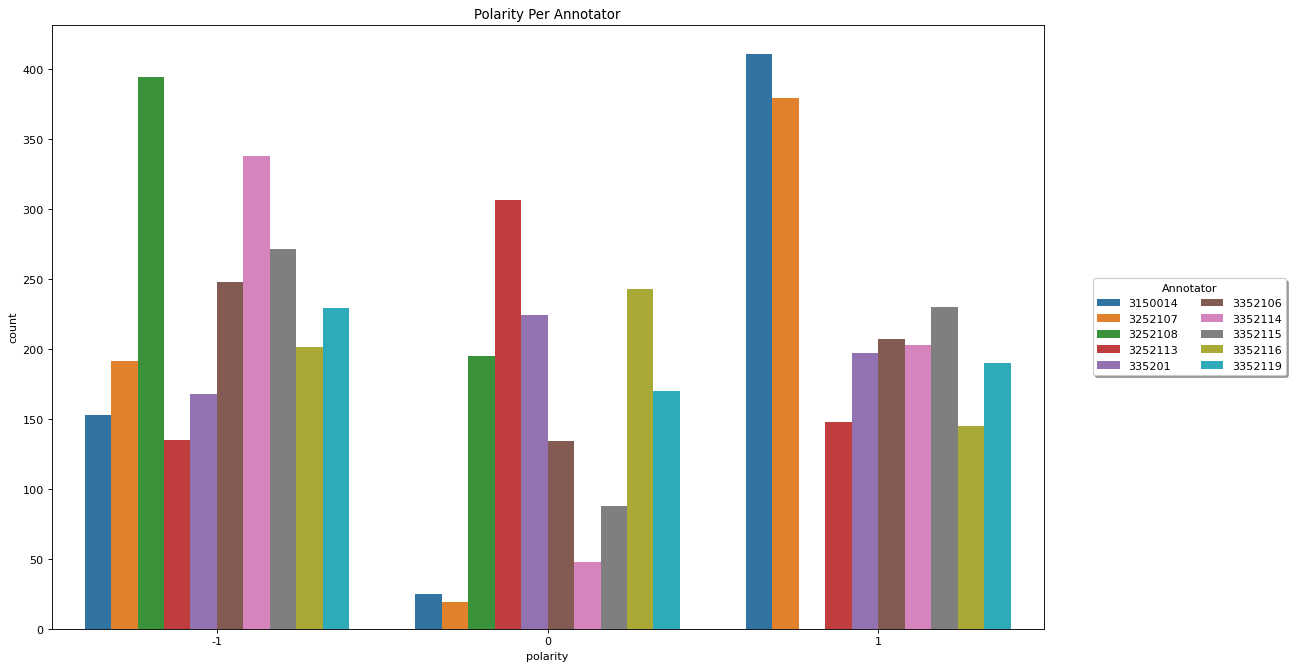

In [29]:
figure(figsize=(16, 10), dpi=80)
polarityplot = sns.countplot(x=coders['polarity'],
                             hue=coders.ID)
plt.legend(title= 'Annotator', loc='right', bbox_to_anchor=(1.25, 0.5),
           ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.title('Polarity Per Annotator')
plt.show(polarityplot)

In [30]:
variance = []
for i in coders.index.unique():
    variance.append(np.var(coders.polarity[i]))
len(variance)

589

In [31]:
coders['variance']= 0.0
for i in coders.index.unique():
    coders.variance[i] = np.var(coders.polarity[i])
coders.variance

verse_id
0      0.56
1      0.65
2      0.36
3      0.36
4      0.41
       ... 
584    0.44
585    0.44
586    0.45
587    0.44
588    0.41
Name: variance, Length: 5890, dtype: float64

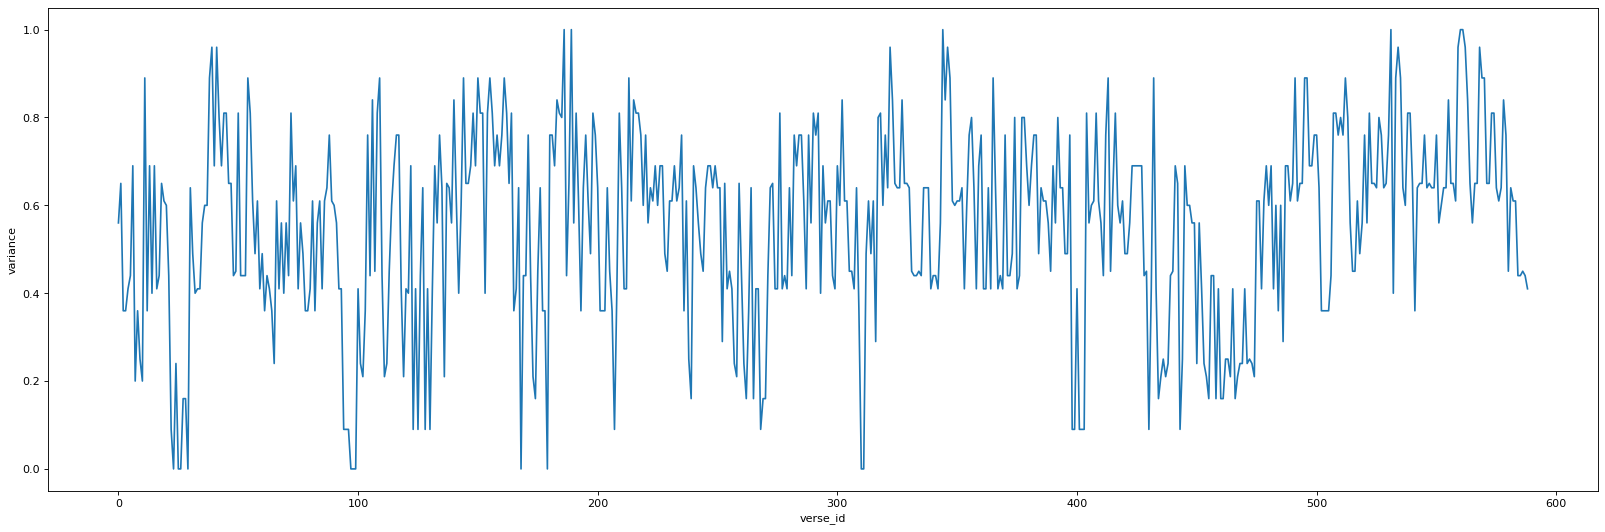

In [32]:
figure(figsize=(25, 8), dpi=80)
sns.lineplot(data= coders[0:589], y=coders.variance[0:589], x=coders.index[0:589])
plt.show()

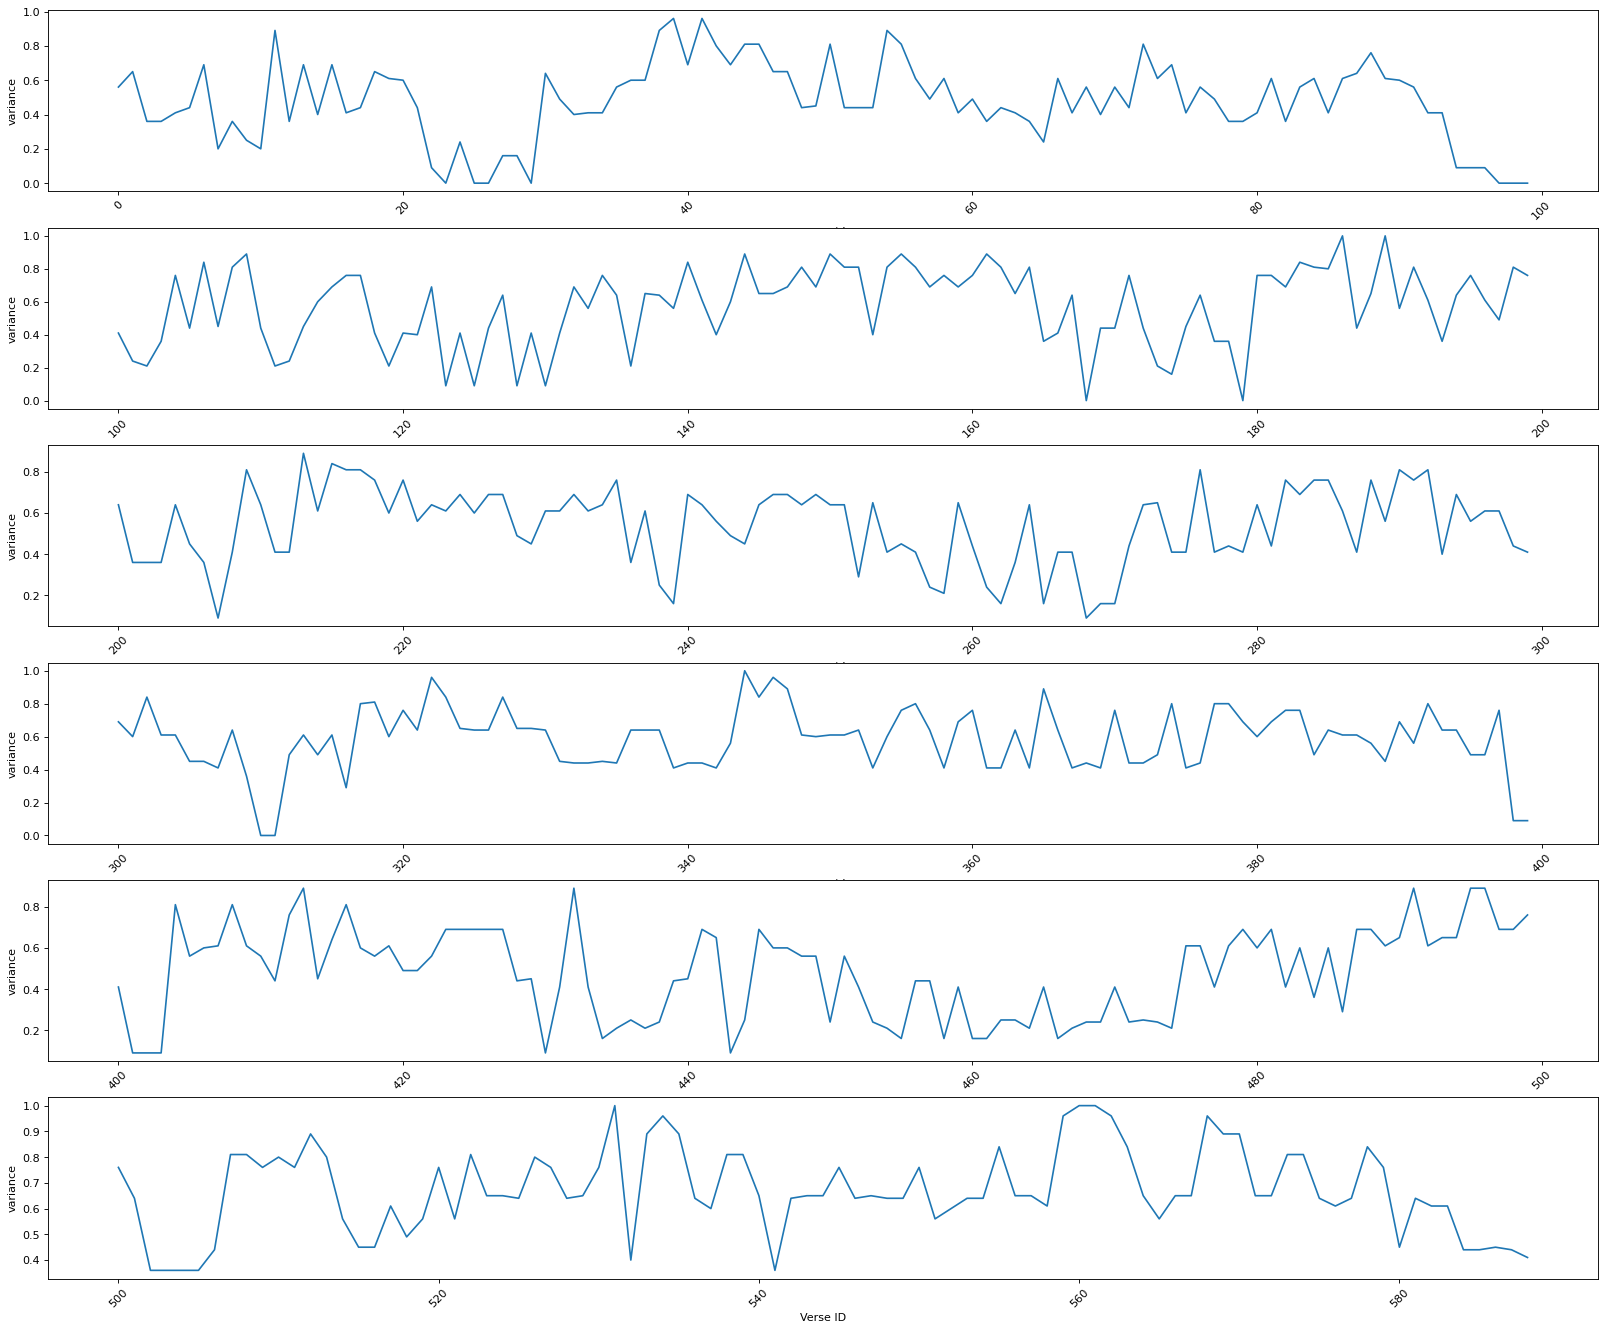

In [33]:
figure(figsize=(25, 21), dpi=80)
plt.subplot(6,1,1)
sns.lineplot(data= coders[0:100], y=coders.variance[0:100], x=coders.index[0:100])
plt.xticks(rotation=45)

plt.subplot(6,1,2)
sns.lineplot(data= coders[100:200], y=coders.variance[100:200], x=coders.index[100:200])
plt.xticks(rotation=45)

plt.subplot(6,1,3)
sns.lineplot(data= coders[200:300], y=coders.variance[200:300], x=coders.index[200:300])
plt.xticks(rotation=45)

plt.subplot(6,1,4)
sns.lineplot(data= coders[300:400], y=coders.variance[300:400], x=coders.index[300:400])
plt.xticks(rotation=45)

plt.subplot(6,1,5)
sns.lineplot(data= coders[400:500], y=coders.variance[400:500], x=coders.index[400:500])
plt.xticks(rotation=45)

plt.subplot(6,1,6)
sns.lineplot(data= coders[500:589], y=coders.variance[500:589], x=coders.index[500:589])
plt.xticks(rotation=45)
plt.xlabel('Verse ID')

plt.show()

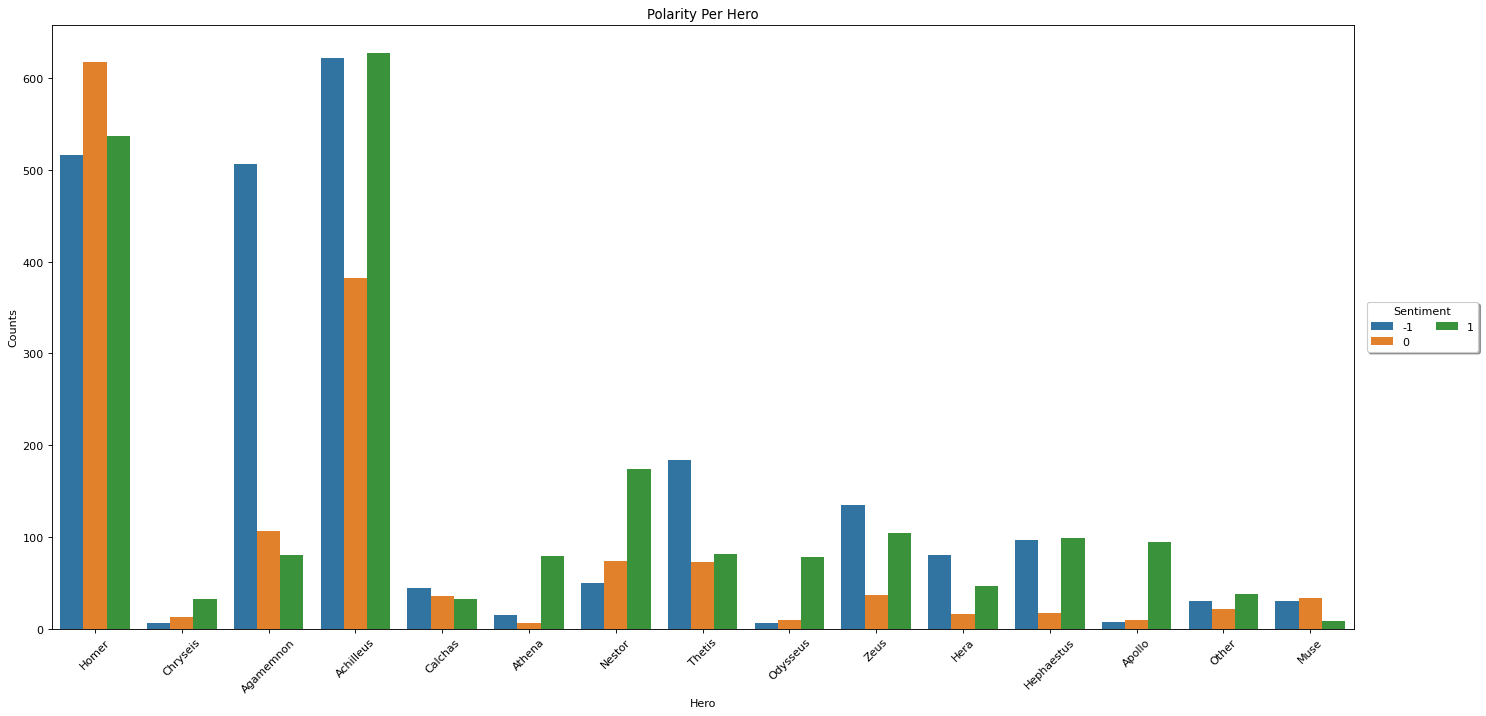

In [34]:
coders.hero.replace(['Briseis', 'Iris', 'Phobos', 'Antenor', 'Andromache', 'Menelaus', 'Chrysis', 'Patroclus'], ['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other' ], inplace=True)
figure(figsize=(21, 10), dpi=80)
emotionsplot = sns.countplot(x=coders['hero'],
                             hue=coders.polarity,
                             )
plt.legend(title= 'Sentiment', loc='right', bbox_to_anchor=(1.10, 0.5),
               ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.xlabel('Hero')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title('Polarity Per Hero')
plt.show(emotionsplot)

In [35]:
coders.reset_index(inplace=True)

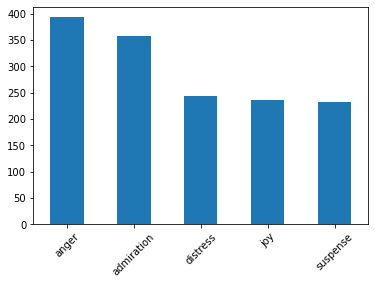

In [36]:
coders.emotions.value_counts()[1:6].plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [37]:
coders.hero.unique()

array(['Homer', 'Chryseis', 'Agamemnon', 'Achilleus', 'Calchas', 'Athena',
       'Nestor', 'Thetis', 'Odysseus', 'Zeus', 'Hera', 'Hephaestus',
       'Apollo', 'Other', 'Muse'], dtype=object)

In [38]:
coders.loc[coders['emotions'].value_counts()[coders['emotions']].values < 100, 'emotions'] = 'Other'
coders.emotions.replace(['neutral'], ['Other'], inplace=True)
coders.emotions.value_counts()

Other              2515
anger               393
admiration          358
distress            244
joy                 236
suspense            232
sadness             202
awe                 182
hope                181
acknowledgement     176
fear                172
respect             160
worry               138
shame               125
pain                122
pride               121
relief              116
satisfaction        114
anxiety             103
Name: emotions, dtype: int64

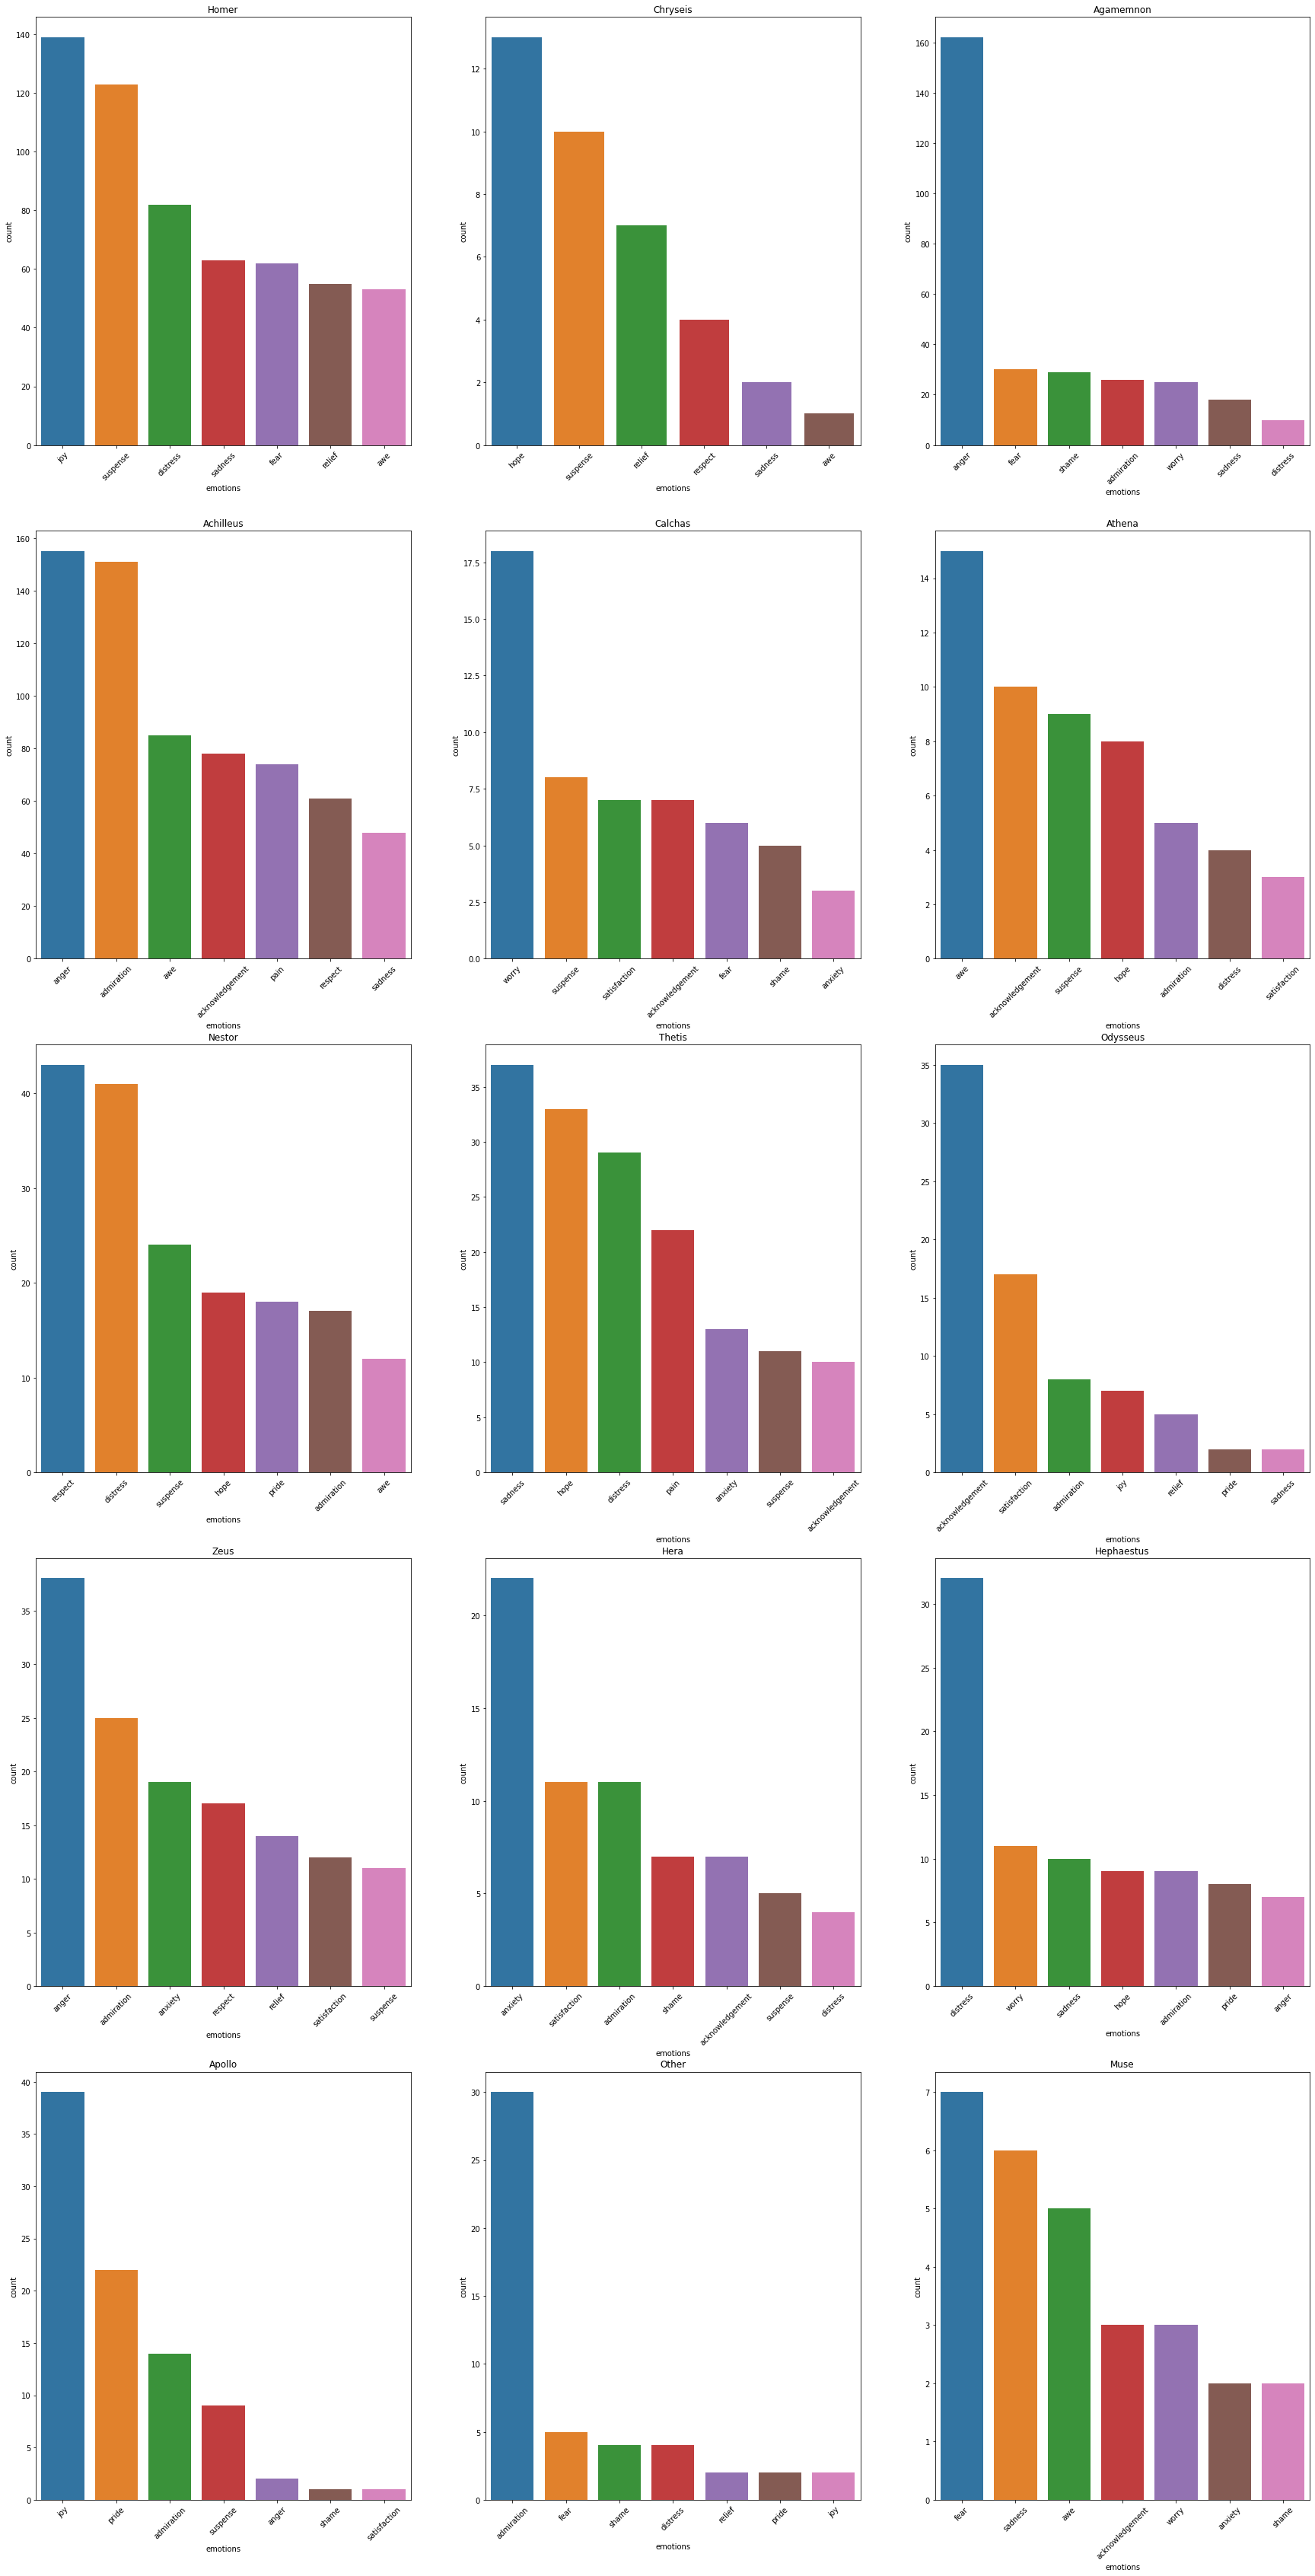

In [39]:
plt.subplots(figsize=(30, 60))
i=1
for hero in coders.hero.unique():
    plt.subplot(5, 3, i)
    sns.countplot(coders.emotions[coders['hero'] == hero].loc[coders['emotions'] != 'Other'], order=coders.emotions[coders['hero'] == hero].loc[coders['emotions'] != 'Other'].value_counts().index[0:7])
    i+= 1
    plt.title(hero)
    plt.xticks(rotation=45)
plt.show()

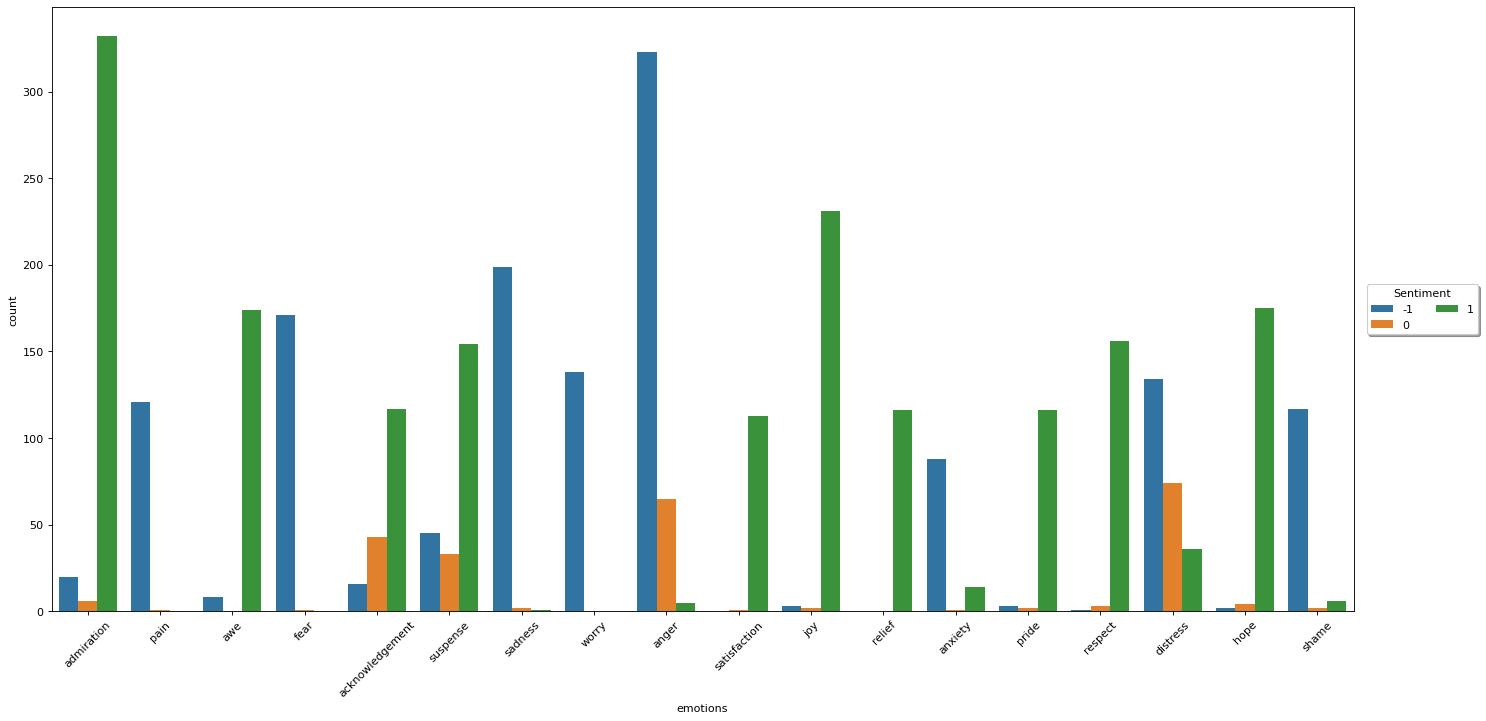

In [40]:
figure(figsize=(21, 10), dpi=80)
sns.countplot(coders.emotions[coders.emotions != 'Other'], hue=coders['polarity'])
plt.legend(title= 'Sentiment', loc='right', bbox_to_anchor=(1.10, 0.5),
           ncol = 2, fancybox=True, shadow=True)
plt.xticks(rotation=45)
plt.show()


### 3. Automated annotation.
 * Build baselines (at least one based on random guesses) and regressors (at least three sklearn-based) that will yield a score (from -1 to 1) estimating the reader's sentiment for an unseen verse. 
 * Evaluate your models using mean absolute error (MAE) and mean square error (MSE). Turn the gold and predicted scores to classes (-1, 0, 1) and evaluate also using *proper* classification evaluation metrics.  
 * Diagnose and analyse any under/over fitting. 
 * Announce a winner based on your evaluation and apply it in order to predict a label (not score) per verse on the 24th Iliad book that is given. Submit your predictions as a compressed CSV with the following title: `IB24.your-student-ID-number.csv.gz`, where `your-student-ID-number` will hold your student ID number). The submitted dataframe should comprise the verses in one column (exactly as the original), but it should also comprise another column to hold the aligned predictions. 

 ---

# T3
For this task, the ground truth for each verse is calculated. The ground truth of one verse is the mean of the polarities given by all annotators for that verse. After that, the gold truth is calculated (mentioned in the code as gold). The gold truth is the mapping of the ground truth. This means that the ground truth is converted into labels. The threshold used to map the ground truth is -0.33 and 0.33 in order to have 3 equal spaces. From -1 to -0.33 the ground truth will be mapped into -1 for the gold truth, -0.33 to 0.33 will be mapped into 0 for the gold and 0.33 to 1 will be mapped into 1. One other idea was to map them using -0.2 and 0.2 as thresholds so that it would have the same amount of polarity values but the idea was dismissed. The new columns were originally set to 0.0 which is float because otherwise when putting float numbers in them, they would be rounded to integers.

After that, a new data frame was created, using the verses of one annotator (which is the same for every annotator), the gold and the ground truth. A baseline column is also created and put into the data frame so that there is one baseline to compare the models. It was created using random integers. The ID, emotions, polarity and hero columns were dropped from the new data frame called auto as they were irrelevant to the models that would be created later.

The verses of the data frame called auto were cleared from symbols and digits so that it could be used for the regressors better. The string library was used in order to create a blacklist with all the symbols (string.panctuation) and some more symbols that were found in the verses were added in that list. Using that list and a for loop, the verses were cleared from symbols. The idea for the blacklist was taken by the reference next to the code which shows how this is done using a whitelist, so with the same mindset, the blacklist was used. Within the for loop, double spaces are created when clearing the data so this issue is addressed using regular expressions and removing the double spaces.

After that, train_test_split was used in order to split the auto dataframe into a train test that consisted of 80% of the original data frame and a test split consisting of the remaining 20%. The data was trained with the verses using vectorizer from TfidfVectorizer and the ground truth found before. A few stop words were passed into the vectorizer and df_max was set to 25 in order to drop words that would appear more than 25 times.

Then, some regressors were used and trained. The regressors that were used are Decision Tree, Linear Regression, Lasso, Ridge, SVR and Random Forest Regressor. The MSE and MAEs were calculated for each one for the test data and compared with the train data errors the overfitting or underfitting can be checked. Of the above, it was found that Linear, Ridge and SVR regressors were found to have overfitting as the train set's error value is too small compared to the test set's error.

When the models have been trained, they have to be evaluated. Each model gives certain continuous predictions. Those values are again mapped into labels using the same method as the ground truth. The labeled predictions are then used along with the gold truth that was calculated before for the model evaluation. The labels were passed into the test data frame for ease of use. The accuracy scores were calculated and classification reports were used to further analyze each model's accuracy. Removing the overfitted models from consideration, the Random Forest Regressor seems to be the best model because it gives values to all polarities. The other models have zero precision and recall for the values of -1 and 1. While lasso has the best accuracy out of the non overfitted models, it seems unable to predict -1 and 1 polarity.

Now that the best model was chosen, the 24th iliad book that was given is converted into a DataFrame. Its verses were cleaned as done previously using the blacklist of symbols and a for loop. The Random Forest Regression model was used in order to predict the sentiments of the 24th iliad book. After that, the predicted sentiment was added as a column to the data frame and the data frame was extracted into a csv which was zipped into gzip.

It seems that the annotators do not agree for several reasons and that makes the models train so that they give many zero values. This way the predictions also give more zero values than they should, resulting in bad predictions.

In [41]:
coders.set_index(['verse_id'], inplace=True)

In [42]:
coders['ground_truth'] = 0.0
coders['gold'] = 0.0
for i in range(0, 589):
    coders['ground_truth'][i] = np.mean(coders.polarity[i])
for i in range(0, 589):
        if coders[0:589]['ground_truth'][i] <= - 0.33:
            coders['gold'][i] = - 1
        elif coders[0:589]['ground_truth'][i] >= 0.33:
            coders['gold'][i] = 1
        else:
            coders['gold'][i] = 0
baseline = list(np.random.randint(-1, 2, 589))
coders['baseline'] = baseline*10

In [43]:
auto = coders[0:589]
auto.drop(['ID', 'emotions', 'polarity', 'hero', 'variance'], axis=1, inplace=True)

In [44]:
auto

,verse,ground_truth,gold,baseline
verse_id,,,,
0,"Τη μάνητα, θεά, τραγούδα μας του ξακουστού Αχι...",0.2,0.0,0
1,"ανάθεμα τη, πίκρες που 'δωκε στους Αχαιούς περ...",-0.5,-1.0,-1
2,και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...,-0.8,-1.0,1
3,"παλικαριών, στους σκύλους ρίχνοντας να φάνε τα...",-0.8,-1.0,1
4,και στα όρνια ολούθε —έτσι το θέλησε να γίνει ...,-0.3,0.0,-1
...,...,...,...,...
584,κει που 'χε χτίσει στον καθένα τους παλάτι ο κ...,0.4,1.0,1
585,"ο ξακουστός τεχνίτης Ήφαιστος, με τη σοφή του ...",0.6,1.0,1
586,"Κι ο Δίας ο Ολύμπιος, ό αστραπόχαρος, στην κλί...",0.5,1.0,0


In [45]:
auto.to_csv('IB1.f3352126.csv.gz', compression='gzip') # Reference: https://stackoverflow.com/questions/37193157/apply-gzip-compression-to-a-csv-in-python-pandas/46073397

In [46]:
blacklist = string.punctuation

In [47]:
blacklist += '᾿«»—·'

In [48]:
for i in range(len(auto)):
    verse_new=''
    for char in auto.verse[i]:
        if char not in blacklist:
            verse_new += char
        else:
            verse_new += ' '
        verse_new = re.sub(' +', ' ', verse_new)
        auto.verse[i] = verse_new #https://stackoverflow.com/questions/875968/how-to-remove-symbols-from-a-string-with-python answer by monkut

In [49]:
auto

,verse,ground_truth,gold,baseline
verse_id,,,,
0,Τη μάνητα θεά τραγούδα μας του ξακουστού Αχιλλέα,0.2,0.0,0
1,ανάθεμα τη πίκρες που δωκε στους Αχαιούς περίσ...,-0.5,-1.0,-1
2,και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...,-0.8,-1.0,1
3,παλικαριών στους σκύλους ρίχνοντας να φάνε τα ...,-0.8,-1.0,1
4,και στα όρνια ολούθε έτσι το θέλησε να γίνει τ...,-0.3,0.0,-1
...,...,...,...,...
584,κει που χε χτίσει στον καθένα τους παλάτι ο κο...,0.4,1.0,1
585,ο ξακουστός τεχνίτης Ήφαιστος με τη σοφή του τ...,0.6,1.0,1
586,Κι ο Δίας ο Ολύμπιος ό αστραπόχαρος στην κλίνη...,0.5,1.0,0


In [50]:
train, test = train_test_split(auto, test_size = 0.20, random_state=15)
vectorizer = TfidfVectorizer(max_df = 25, stop_words={'η', 'ο', 'το','στ', 'απ', 'απο', 'από', 'στο', 'στον' , 'στην', 'μας', 'μη', 'μην', 'σας', 'αλλά', 'άλλος', 'και', 'κι', 'άλλη' , 'ασε', 'πως', 'που', 'σας', 'σου', 'σε', 'ή', 'χε', 'στη','αυτόν', 'αυτούς', 'πολλά', 'έτσι', 'στα', 'τι', 'να', 'θ', 'με', 'σε', 'αν', 'στις', 'αφού', 'γιατί', 'έχει', 'έχω', 'πώς', 'ναι', 'όχι', 'πού', 'γι', 'ουδ', 'χεις', 'μ', 'Κι', 'μα', 'Τότε', 'τότε', 'για', 'Γι', 'Ο', "Η",'Το', 'Μα', 'Ποτέ', 'Ποιος', 'ποιός', 'Έτσι'})
X = vectorizer.fit_transform(train.verse)
y = train.ground_truth

In [51]:
# Decision Tree Regression
coders_tree = DecisionTreeRegressor(max_depth=3)
coders_tree.fit(X, y)
predictions = coders_tree.predict(vectorizer.transform(test.verse))
predictions_train = coders_tree.predict(vectorizer.transform(train.verse))
tree_MSE = mean_squared_error(test.ground_truth, predictions)
tree_MAE = mean_absolute_error(test.ground_truth, predictions)
tree_MSE_train = mean_squared_error(train.ground_truth, predictions_train)
tree_MAE_train = mean_absolute_error(train.ground_truth, predictions_train)
print(f'Decision Tree Regression MSE: {tree_MSE}\nDecision Tree Regression MAE: {tree_MAE}')
print(f'Train Decision Tree Regression MSE: {tree_MSE_train}\nTrain Decision Tree Regression MAE: {tree_MAE_train}')

Decision Tree Regression MSE: 0.25752959508129164
Decision Tree Regression MAE: 0.41023383212618103
Train Decision Tree Regression MSE: 0.18252094357784013
Train Decision Tree Regression MAE: 0.35213350465847804


In [52]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X, y)
linreg_predictions = linreg.predict(vectorizer.transform(test.verse))
linreg_predictions_train = linreg.predict(vectorizer.transform(train.verse))
linreg_MSE = mean_squared_error(test.ground_truth, linreg_predictions)
linreg_MAE = mean_absolute_error(test.ground_truth, linreg_predictions)
linreg_MSE_train = mean_squared_error(train.ground_truth, linreg_predictions_train)
linreg_MAE_train = mean_absolute_error(train.ground_truth, linreg_predictions_train)
print(f'Linear Regression MSE: {linreg_MSE}\nLinear Regression MAE: {linreg_MAE}')
print(f'Train Linear Regression MSE: {linreg_MSE_train}\nTrain Linear Regression MAE: {linreg_MAE_train}')

Linear Regression MSE: 0.2882573775864989
Linear Regression MAE: 0.4175774473813951
Train Linear Regression MSE: 0.00041755130927105766
Train Linear Regression MAE: 0.0028308575825947823


In [53]:
# Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
lasso_predictions = lasso.predict(vectorizer.transform(test.verse))
lasso_predictions_train = lasso.predict(vectorizer.transform(train.verse))
lasso_MSE = mean_squared_error(test.ground_truth, lasso_predictions)
lasso_MAE = mean_absolute_error(test.ground_truth, lasso_predictions)
lasso_MSE_train = mean_squared_error(train.ground_truth, lasso_predictions_train)
lasso_MAE_train = mean_absolute_error(train.ground_truth, lasso_predictions_train)
print(f'Lasso Regression MSE: {lasso_MSE}\nLasso Regression MAE: {lasso_MAE}')
print(f'Train Lasso Regression MSE: {lasso_MSE_train}\nTrain Lasso Regression MAE: {lasso_MAE_train}')

Lasso Regression MSE: 0.223620732638027
Lasso Regression MAE: 0.3919860376407932
Train Lasso Regression MSE: 0.19415644538205293
Train Lasso Regression MAE: 0.3664345184163433


In [54]:
# Ridge Regression
ridge = Ridge(alpha=0.01)
ridge.fit(X, y)
ridge_predictions = ridge.predict(vectorizer.transform(test.verse))
ridge_predictions_train = ridge.predict(vectorizer.transform(train.verse))
ridge_MSE = mean_squared_error(test.ground_truth, ridge_predictions)
ridge_MAE = mean_absolute_error(test.ground_truth, ridge_predictions)
ridge_MSE_train = mean_squared_error(train.ground_truth, ridge_predictions_train)
ridge_MAE_train = mean_absolute_error(train.ground_truth, ridge_predictions_train)
print(f'Ridge Regression MSE: {ridge_MSE}\nRidge Regression MAE: {ridge_MAE}')
print(f'Train Ridge Regression MSE: {ridge_MSE_train}\nTrain Ridge Regression MAE: {ridge_MAE_train}')

Ridge Regression MSE: 0.28591995104303525
Ridge Regression MAE: 0.416143979810401
Train Ridge Regression MSE: 0.00045930217840981576
Train Ridge Regression MAE: 0.007870711599397453


In [55]:
# Random Forest Regressor
forest = RandomForestRegressor(n_estimators=50)
forest.fit(X, y)
forest_predictions = forest.predict(vectorizer.transform(test.verse))
forest_predictions_train = forest.predict(vectorizer.transform(train.verse))
forest_MSE = mean_squared_error(test.ground_truth, forest_predictions)
forest_MAE = mean_absolute_error(test.ground_truth, forest_predictions)
forest_MSE_train = mean_squared_error(train.gold, forest_predictions_train)
forest_MAE_train = mean_absolute_error(train.gold, forest_predictions_train)
print(f'Random Forest Regression MSE: {forest_MSE}\nRandom Forest MAE: {forest_MAE}')
print(f'Train Random Forest Regression MSE: {forest_MSE_train}\nTrain Random Forest MAE: {forest_MAE_train}')

Random Forest Regression MSE: 0.26633265810369344
Random Forest MAE: 0.41949798224374485
Train Random Forest Regression MSE: 0.1925820667075889
Train Random Forest MAE: 0.3437660095035892


In [56]:
# Support Vector Regression
svmreg = svm.SVR()
svmreg.fit(X, y)
svm_predictions = svmreg.predict(vectorizer.transform(test.verse))
svm_predictions_train = svmreg.predict(vectorizer.transform(train.verse))
svm_MSE = mean_squared_error(test.ground_truth, svm_predictions)
svm_MAE = mean_absolute_error(test.ground_truth, svm_predictions)
svm_MSE_train = mean_squared_error(train.ground_truth, svm_predictions_train)
svm_MAE_train = mean_absolute_error(train.ground_truth, svm_predictions_train)
print(f'Support Vector Machine MSE: {svm_MSE}\nSupport Vector Machine MAE: {svm_MAE}')
print(f'Train Support Vector Machine MSE: {svm_MSE_train}\nTrain Support Vector Machine MAE: {svm_MAE_train}')

Support Vector Machine MSE: 0.22383068146522106
Support Vector Machine MAE: 0.38433333553479704
Train Support Vector Machine MSE: 0.009462362360442811
Train Support Vector Machine MAE: 0.09452198788309858


In [57]:
test.reset_index(inplace=True)

In [58]:
test['tree_predictions'] = predictions
test['tree_predictions_map'] = 0.0

test['linreg_predictions'] = linreg_predictions
test['linreg_predictions_map'] = 0.0

test['lasso_predictions'] = lasso_predictions
test['lasso_predictions_map'] = 0.0

test['ridge_predictions'] = ridge_predictions
test['ridge_predictions_map'] = 0.0

test['forest_predictions'] = forest_predictions
test['forest_predictions_map'] = 0.0

test['svm_predictions'] = svm_predictions
test['svm_predictions_map'] = 0.0

for i in test.index:
    if test['tree_predictions'][i] <= - 0.33:
        test['tree_predictions_map'][i] = - 1
    elif test['tree_predictions'][i] >= 0.2:
        test['tree_predictions_map'][i] = 1
    else:
        test['tree_predictions_map'][i] = 0
for i in test.index:
    if test['lasso_predictions'][i] <= - 0.33:
        test['lasso_predictions_map'][i] = - 1
    elif test['lasso_predictions'][i] >= 0.33:
        test['lasso_predictions_map'][i] = 1
    else:
        test['lasso_predictions_map'][i] = 0
for i in test.index:
    if test['linreg_predictions'][i] <= - 0.33:
        test['linreg_predictions_map'][i] = - 1
    elif test['linreg_predictions'][i] >= 0.33:
        test['linreg_predictions_map'][i] = 1
    else:
        test['linreg_predictions_map'][i] = 0
for i in test.index:
    if test['ridge_predictions'][i] <= - 0.33:
        test['ridge_predictions_map'][i] = - 1
    elif test['ridge_predictions'][i] >= 0.33:
        test['ridge_predictions_map'][i] = 1
    else:
        test['ridge_predictions_map'][i] = 0
for i in test.index:
    if test['forest_predictions'][i] <= - 0.33:
        test['forest_predictions_map'][i] = - 1
    elif test['forest_predictions'][i] >= 0.33:
        test['forest_predictions_map'][i] = 1
    else:
        test['forest_predictions_map'][i] = 0
for i in test.index:
    if test['svm_predictions'][i] <= - 0.33:
        test['svm_predictions_map'][i] = - 1
    elif test['svm_predictions'][i] >= 0.33:
        test['svm_predictions_map'][i] = 1
    else:
        test['svm_predictions_map'][i] = 0

In [59]:
print(f'Decision Tree Accuracy Score: {accuracy_score(test.gold,test.tree_predictions_map)}\nLinear Regression Accuracy Score: {accuracy_score(test.gold, test.linreg_predictions_map)}\nLasso Accuracy Score: {accuracy_score(test.gold,test.lasso_predictions_map)}\nRidge Regression Accuracy Score: {accuracy_score(test.gold, test.ridge_predictions_map)}\nRandom Forst Accuracy Score: {accuracy_score(test.gold, test.forest_predictions_map)}\nSVM Accuracy Score: {accuracy_score(test.gold, test.svm_predictions_map)}')

Decision Tree Accuracy Score: 0.5084745762711864
Linear Regression Accuracy Score: 0.5084745762711864
Lasso Accuracy Score: 0.5169491525423728
Ridge Regression Accuracy Score: 0.5084745762711864
Random Forst Accuracy Score: 0.5
SVM Accuracy Score: 0.5169491525423728


In [60]:
print(classification_report(test.gold, test.tree_predictions_map))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        28
         0.0       0.52      0.98      0.68        61
         1.0       0.00      0.00      0.00        29

    accuracy                           0.51       118
   macro avg       0.17      0.33      0.23       118
weighted avg       0.27      0.51      0.35       118



In [61]:
print(classification_report(test.gold, test.linreg_predictions_map))

              precision    recall  f1-score   support

        -1.0       0.41      0.32      0.36        28
         0.0       0.55      0.77      0.64        61
         1.0       0.40      0.14      0.21        29

    accuracy                           0.51       118
   macro avg       0.45      0.41      0.40       118
weighted avg       0.48      0.51      0.47       118



In [62]:
print(classification_report(test.gold, test.lasso_predictions_map))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        28
         0.0       0.52      1.00      0.68        61
         1.0       0.00      0.00      0.00        29

    accuracy                           0.52       118
   macro avg       0.17      0.33      0.23       118
weighted avg       0.27      0.52      0.35       118



In [63]:
print(classification_report(test.gold, test.ridge_predictions_map))

              precision    recall  f1-score   support

        -1.0       0.41      0.32      0.36        28
         0.0       0.55      0.77      0.64        61
         1.0       0.40      0.14      0.21        29

    accuracy                           0.51       118
   macro avg       0.45      0.41      0.40       118
weighted avg       0.48      0.51      0.47       118



In [64]:
print(classification_report(test.gold, test.svm_predictions_map))

              precision    recall  f1-score   support

        -1.0       0.50      0.04      0.07        28
         0.0       0.52      0.98      0.68        61
         1.0       0.00      0.00      0.00        29

    accuracy                           0.52       118
   macro avg       0.34      0.34      0.25       118
weighted avg       0.39      0.52      0.37       118



In [65]:
print(classification_report(test['gold'], test['forest_predictions_map']))

              precision    recall  f1-score   support

        -1.0       0.33      0.14      0.20        28
         0.0       0.53      0.87      0.66        61
         1.0       0.33      0.07      0.11        29

    accuracy                           0.50       118
   macro avg       0.40      0.36      0.32       118
weighted avg       0.43      0.50      0.42       118



In [66]:
print(classification_report(test.gold, test.baseline))

              precision    recall  f1-score   support

        -1.0       0.15      0.25      0.19        28
         0.0       0.44      0.28      0.34        61
         1.0       0.24      0.28      0.26        29

    accuracy                           0.27       118
   macro avg       0.28      0.27      0.26       118
weighted avg       0.32      0.27      0.28       118



In [67]:
i24 = pd.read_excel(r'..\\I24.xlsx')

In [68]:
for i in range(len(i24)):
    verse_new=''
    for char in i24.verse[i]:
        if char not in blacklist:
            verse_new += char
        else:
            verse_new += ' '
        verse_new = re.sub(' +', ' ', verse_new)
        i24.verse[i] = verse_new

In [69]:
pred = forest.predict(vectorizer.transform(i24.verse))

In [70]:
i24['sentiment'] = 0.0
i24.sentiment = pred

In [71]:
for i in i24.index:
    if i24['sentiment'][i] <= - 0.33:
        i24['sentiment'][i] = - 1
    elif i24['sentiment'][i] >= 0.33:
        i24['sentiment'][i] = 1
    else:
        i24['sentiment'][i] = 0

In [72]:
i24.sentiment.value_counts()

 0.0    764
-1.0     48
 1.0     18
Name: sentiment, dtype: int64

In [73]:
i24

,verse,sentiment
0,Λύθηκε η σύναξη στα γρήγορα καράβια του τ ασκέρι,0.0
1,πίσω γυρνάει σκορπώντας κι όλοι τους το δείπνο...,0.0
2,και το γλυκό τον ύπνο εγνοιάζουνταν Μόνο ο Αχι...,0.0
3,το σύντροφο του αναθυμάμενος κι ουδέ καθόλου ο...,-1.0
4,ο παντοδαμαστής τον έπιανε μον γύρναε δώθε κείθε,0.0
...,...,...
825,μην τύχει πριν και πέσουν πάνω τους οι Αργίτες...,0.0
826,Κι ως πια ψηλά το χώμα εσώρωσαν γυρνούν και φε...,0.0
827,μετά σε πλούσιες τάβλες έτρωγαν με τάξη συναγμ...,0.0
828,μέσα στου Πριάμου του τρισεύγενου ρηγάρχη το π...,0.0


In [74]:
i24.to_csv('IB24.f3352126.csv.gz', compression='gzip') # Reference https://stackoverflow.com/questions/37193157/apply-gzip-compression-to-a-csv-in-python-pandas/46073397


### 4. Scraping and silver labeling.
 * Scrape all the books of Iliad, by using this [translation from Project Gutenberg](https://www.gutenberg.org/cache/epub/36248/pg36248-images.html).
 * Use your best performing sentiment classifier from (3) to label the verses of all the 24 crawled books (silver labeling).  
 * Visualise the sentiment series resulted from the silver labels of all the books. 
 * Evaluate your model's predictions for the 1st scraped book with the respective gold annotations (of the same book from T3, yet with a different translation), which you used to train your model.

# T4
By examining the site, it is shown that what needs to be taken from the site is the text between the td of the html code. Using BeautifulSoup, the text part is kept into a list using a for loop. Within the for loop, using an if statement, with the help of the function .isdigit(), the numbers from the verses are not kept and with the function len(td.get_text()) > 2, the rhapsody names are also not kept into the list (the 2 is used for the rhapsody ΣΤ in particular). Later into the task it is required to have the first rhapsody so with another for loop and by ordering the for loop to break if the text is B (the beginning of the second Rhapsody), the first book is kept. Some verses had their numbers kept into the list so using regular expressions as shown in the reference, the digits are removed from within the verses. Also, again using the blacklist of symbols, those symbols are removed as well for both the iliad_df which is the whole site's texts as well as the iliad first df which is the data frame of the first rhapsody of the site. The Random Forest Regressor is once again used to predict the sentiments for each of the two data frames. The predicted sentiments are passed into the data frames as a new column. A count plot is plotted to review the predicted sentiments of the whole iliad.

By comparing the plots of the two data frames' sentiments a conclusion is drawn that the sentiments between the two do not much. The scatter plot and the lineplot show that in the auto data frame the sentiments are more scattered, while in the iliad_df it is shown that the sentiments are gathered in the middle, which means more zero values. Through the pie chart one can see that the percentage of zeros in the iliad_df is way higher than that of the auto data frame.


In [75]:
r = requests.get('https://www.gutenberg.org/cache/epub/36248/pg36248-images.html')
html = r.content
soup = BeautifulSoup(html, 'html.parser')
text = soup.find_all('td')
iliad = []
iliad_first = []
for td in text:
    if td.get_text().isdigit() is False and len(td.get_text()) > 2:
        iliad.append(td.get_text().strip())
for td in text:
    if td.get_text().strip() == 'Β':
        break
    else:
        if td.get_text().isdigit() is False and len(td.get_text()) > 2:
            iliad_first.append(td.get_text().strip())


In [76]:
pattern = r'[0-9]'
for i in range(len(iliad_first)):
    iliad_first[i] = re.sub(pattern, '', iliad_first[i])
iliad_first_df = pd.DataFrame(iliad_first, columns=['verse'])

In [77]:
iliad_first_df

,verse
0,"Μούσα, τραγούδα το θυμό του ξακουστού Αχιλέα,"
1,"τον έρμο! π' όλους πότισε τους Αχαιούς φαρμάκια,"
2,και πλήθος έστειλε ψυχές λεβέντικες στον Άδη
3,"οπλαρχηγώνε, κι' έθρεψε με τα κορμιά τους σκύλους"
4,κι' όλα τα όρνια (του Διός έτσι είχε η γνώμη ο...
...,...
645,πρωτοτεχνίτης Ήφαιστος με τη σοφή του τέχνη·
646,κι' ο Δίας ο αστραπεφτής ο συγνεφοσυνάχτης
647,"στο στρώμα πάγαινε κι' αφτός, όπου κοιμούνταν ..."
648,ύπνος σαν τούρχουνταν γλυκός. Απάνου εκεί γυρμ...


In [78]:
for i in range(len(iliad)):
    iliad[i] = re.sub(pattern, '', iliad[i]) # remove numbers using regular expressions: https://www.studytonight.com/python-howtos/remove-numbers-from-string-in-python

In [79]:
iliad_df = pd.DataFrame(iliad, columns=['verse'])

In [80]:
for i in range(len(iliad_df)):
    verse_new=''
    for char in iliad_df.verse[i]:
        if char not in blacklist:
            verse_new += char
        else:
            verse_new += ' '
        verse_new = re.sub(' +', ' ', verse_new)
        iliad_df.verse[i] = verse_new

In [81]:
iliad_df

,verse
0,Μούσα τραγούδα το θυμό του ξακουστού Αχιλέα
1,τον έρμο π όλους πότισε τους Αχαιούς φαρμάκια
2,και πλήθος έστειλε ψυχές λεβέντικες στον Άδη
3,οπλαρχηγώνε κι έθρεψε με τα κορμιά τους σκύλους
4,κι όλα τα όρνια του Διός έτσι είχε η γνώμη ορί...
...,...
12700,παντού σκοπούς μην τύχει πριν κι οι Δαναοί πλα...
12701,Κι αφού το μνήμα τέλειωσαν παν πίσω και κατόπι
12702,μαζέβουνται όλοι ταχτικά και κάθουνται να φάνε
12703,στον πύργο του διόσπαρτου του βασιλιά Πριάμου


In [82]:
iliad_df['sentiment'] = 0.0
iliad_df_predictions = forest.predict(vectorizer.transform(iliad_df.verse))
iliad_df['sentiment'] = iliad_df_predictions

In [83]:
for i in iliad_df.index:
    if iliad_df['sentiment'][i] < - 0.33:
        iliad_df['sentiment'][i] = - 1
    elif iliad_df['sentiment'][i] > 0.33:
        iliad_df['sentiment'][i] = 1
    else:
        iliad_df['sentiment'][i] = 0

In [84]:
iliad_df

,verse,sentiment
0,Μούσα τραγούδα το θυμό του ξακουστού Αχιλέα,0.0
1,τον έρμο π όλους πότισε τους Αχαιούς φαρμάκια,0.0
2,και πλήθος έστειλε ψυχές λεβέντικες στον Άδη,0.0
3,οπλαρχηγώνε κι έθρεψε με τα κορμιά τους σκύλους,0.0
4,κι όλα τα όρνια του Διός έτσι είχε η γνώμη ορί...,0.0
...,...,...
12700,παντού σκοπούς μην τύχει πριν κι οι Δαναοί πλα...,0.0
12701,Κι αφού το μνήμα τέλειωσαν παν πίσω και κατόπι,0.0
12702,μαζέβουνται όλοι ταχτικά και κάθουνται να φάνε,0.0
12703,στον πύργο του διόσπαρτου του βασιλιά Πριάμου,0.0


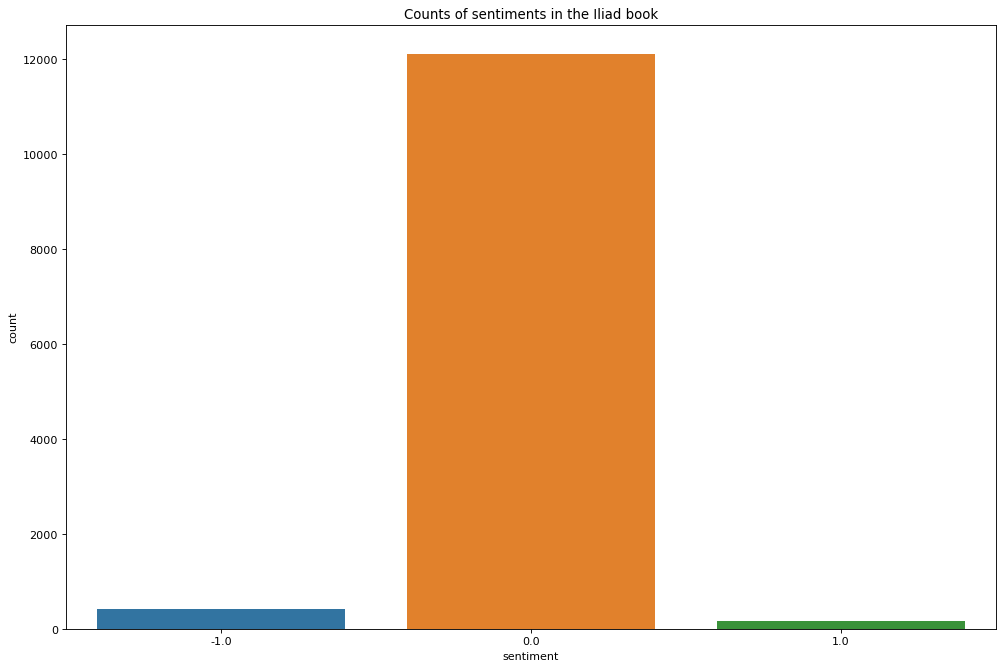

In [85]:
figure(figsize=(15, 10), dpi=80)
iliad_sentiment_plot = sns.countplot(iliad_df.sentiment)
plt.title('Counts of sentiments in the Iliad book')
plt.show(iliad_sentiment_plot)

In [86]:
for i in range(len(iliad_first_df)):
    verse_new=''
    for char in iliad_first_df.verse[i]:
        if char not in blacklist:
            verse_new += char
        else:
            verse_new += ' '
        verse_new = re.sub(' +', ' ', verse_new)
        iliad_first_df.verse[i] = verse_new

In [87]:
iliad_first_df['sentiment'] = 0.0
iliad_first_df_predictions = forest.predict(vectorizer.transform(iliad_first_df.verse))
iliad_first_df['sentiment'] = iliad_first_df_predictions
for i in iliad_first_df.index:
    if iliad_first_df['sentiment'][i] < - 0.33:
        iliad_first_df['sentiment'][i] = - 1
    elif iliad_first_df['sentiment'][i] > 0.33:
        iliad_first_df['sentiment'][i] = 1
    else:
        iliad_first_df['sentiment'][i] = 0

In [88]:
iliad_first_df

,verse,sentiment
0,Μούσα τραγούδα το θυμό του ξακουστού Αχιλέα,0.0
1,τον έρμο π όλους πότισε τους Αχαιούς φαρμάκια,0.0
2,και πλήθος έστειλε ψυχές λεβέντικες στον Άδη,0.0
3,οπλαρχηγώνε κι έθρεψε με τα κορμιά τους σκύλους,0.0
4,κι όλα τα όρνια του Διός έτσι είχε η γνώμη ορί...,0.0
...,...,...
645,πρωτοτεχνίτης Ήφαιστος με τη σοφή του τέχνη,0.0
646,κι ο Δίας ο αστραπεφτής ο συγνεφοσυνάχτης,0.0
647,στο στρώμα πάγαινε κι αφτός όπου κοιμούνταν πά...,0.0
648,ύπνος σαν τούρχουνταν γλυκός Απάνου εκεί γυρμένος,0.0


<AxesSubplot:xlabel='verse_id', ylabel='gold'>

<Figure size 2400x800 with 0 Axes>

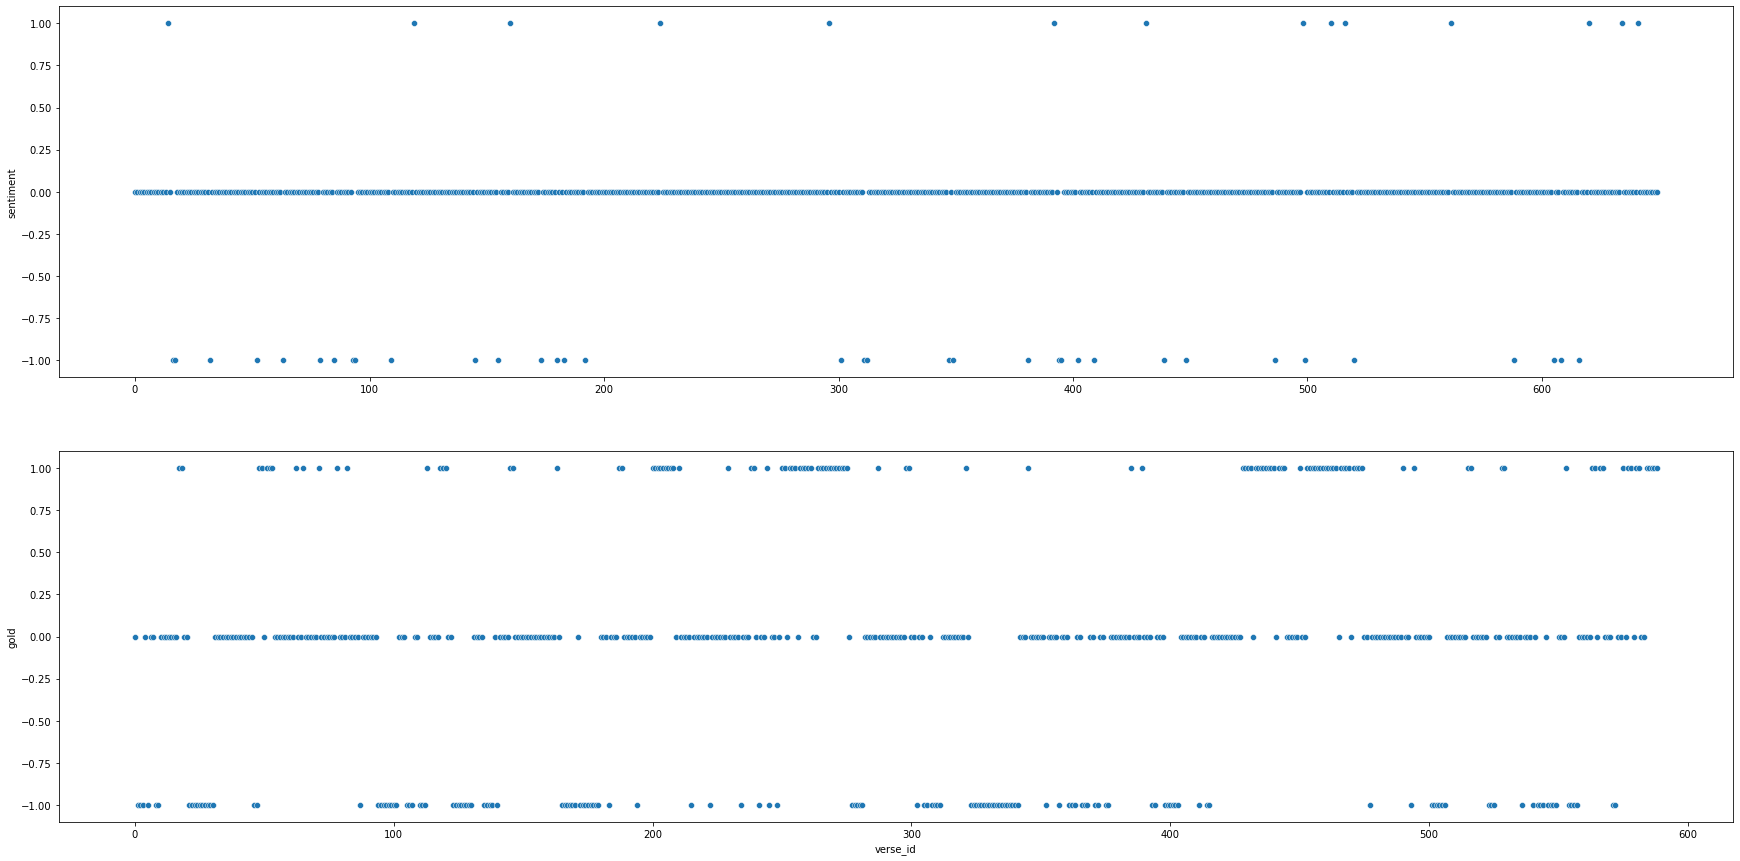

In [89]:
figure(figsize=(30, 10), dpi=80)
plt.subplots(figsize=(30,15))
plt.subplot(2, 1, 1)
sns.scatterplot(data= iliad_first_df, y='sentiment', x=iliad_first_df.index)

plt.subplot(2, 1, 2)
sns.scatterplot(data= auto, y='gold', x=auto.index)

<AxesSubplot:xlabel='verse_id', ylabel='gold'>

<Figure size 2400x800 with 0 Axes>

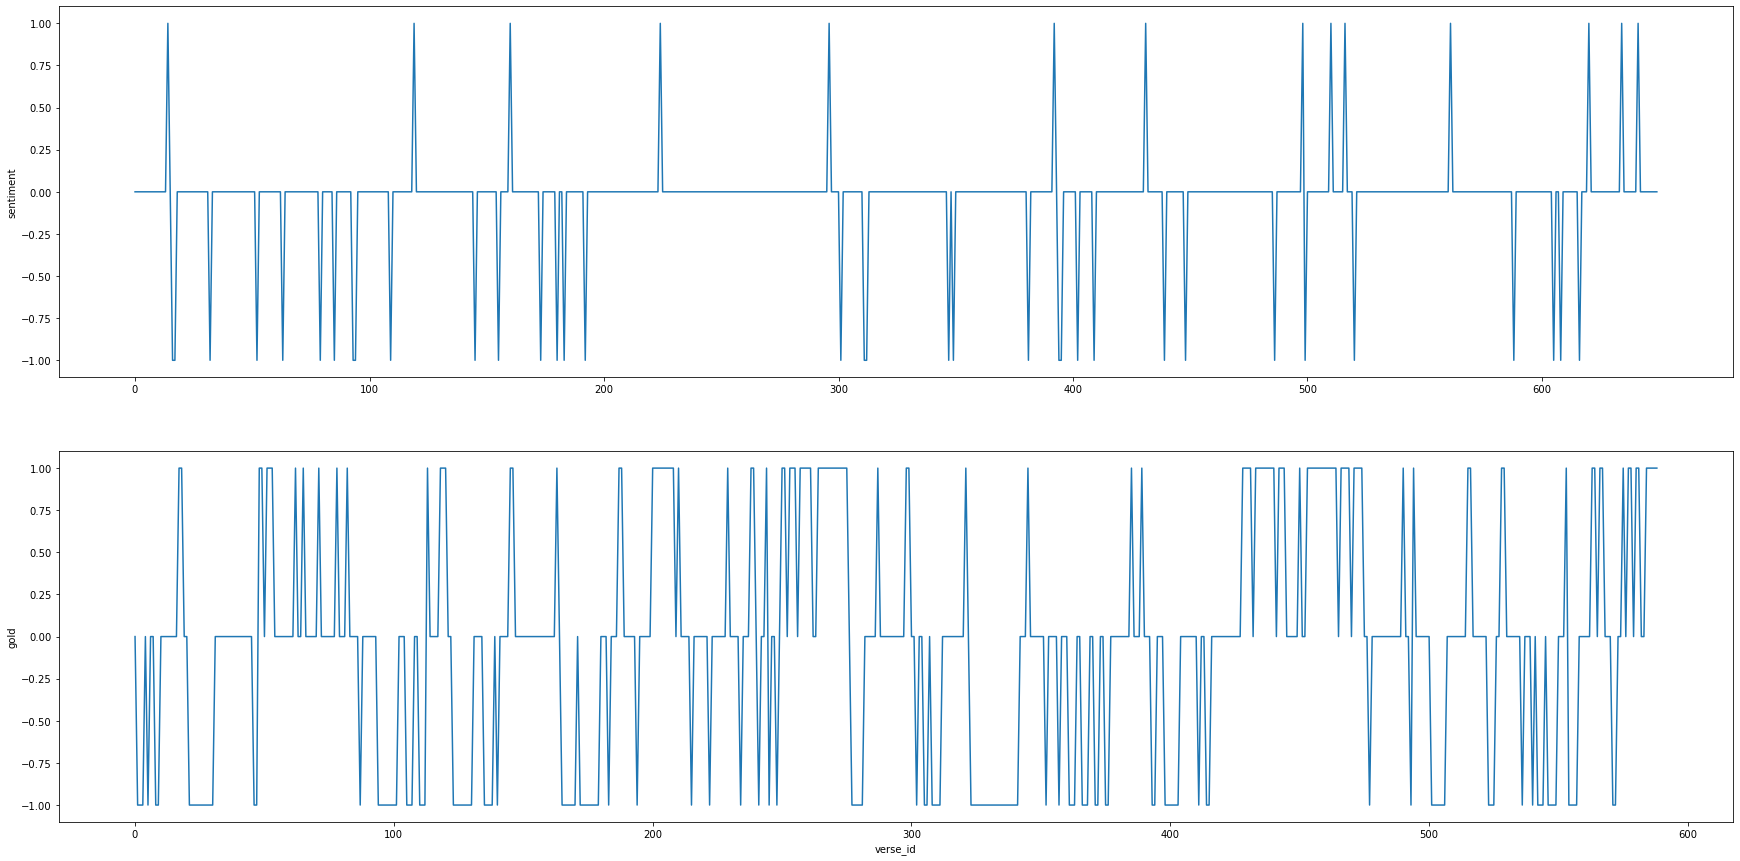

In [90]:
figure(figsize=(30, 10), dpi=80)
plt.subplots(figsize=(30,15))
plt.subplot(2, 1, 1)
sns.lineplot(data= iliad_first_df, y='sentiment', x=iliad_first_df.index)

plt.subplot(2, 1, 2)
sns.lineplot(data= auto, y='gold', x=auto.index)

In [91]:
iliad_first_df.sentiment.value_counts(normalize=True)

 0.0    0.924615
-1.0    0.053846
 1.0    0.021538
Name: sentiment, dtype: float64

In [92]:
auto.gold.value_counts(normalize=True)

 0.0    0.543294
-1.0    0.251273
 1.0    0.205433
Name: gold, dtype: float64

<Figure size 2400x800 with 0 Axes>

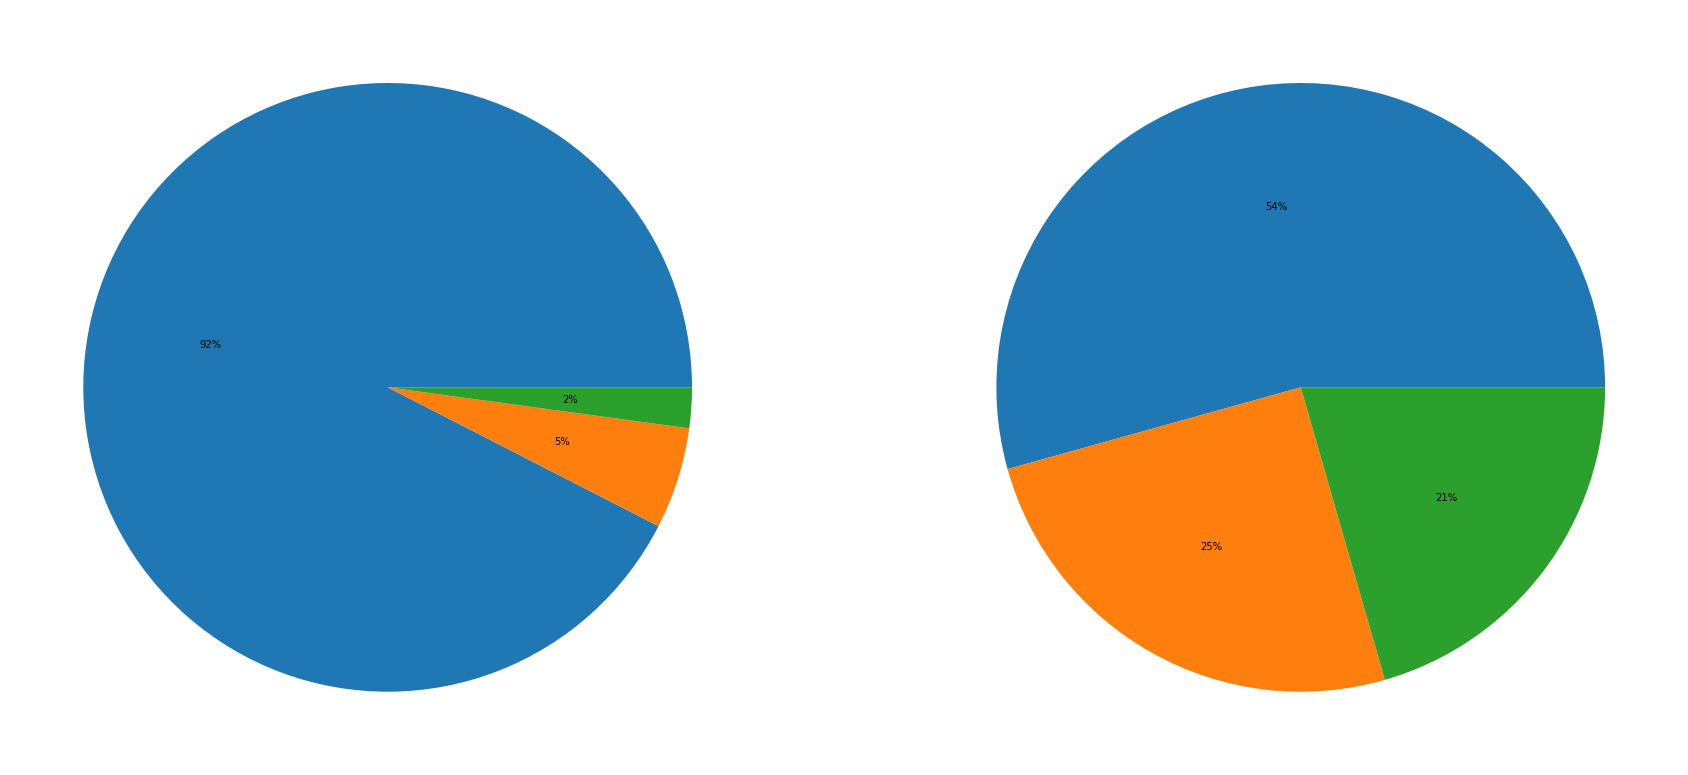

In [93]:
figure(figsize=(30, 10), dpi=80)
plt.subplots(figsize=(30,15))
plt.subplot(1, 2, 1)
plt.pie(iliad_first_df.sentiment.value_counts(), autopct='%1.0f%%')

plt.subplot(1, 2, 2)
plt.pie(auto.gold.value_counts(), autopct='%1.0f%%')

plt.show()

In [94]:
iliad_df.to_csv('iliad_from_gutenberg.f3352126.csv.gz', compression='gzip')

One can conclude that the models can not be trained properly due to the fact that the annotators seem to have put too many different values for polarities. Due to that fact, the models are trained so that many sentiments are zero.

###  BONUS:  

Try to improve your best performing model, in order to better generalise. Your labels of the 24th will be compared against those of a quality annotator to evaluate your model. The top five scores will receive a bonus of 10%. 

---

In [ ]:
# Bonus coding...


### Submission: 
* A zipped folder (only ZIP, not RAR), with your student ID number as name (e.g., f12345.zip), which will include the following files: 
  * The notebook with the tasks and the solutions, named as: `your-student-ID-number.ipynb`.
  * The dataframe with the ground truth annotations from the second task (T2) named as: `IB1.your-student-ID-number.csv.gz`
  * The predictions for the 24th book (from T3), named as: `IB24.your-student-ID-number.csv.gz`
  * The dataframe with the silver annotations of all the scrapped books (from T4), using a long format and named as: `iliad_from_gutenberg.your-student-ID-number.csv.gz`

### Evaluation criteria: 
  * The four tasks are equally weighted in terms of grades (25% each). 
  * With this assignment you are expected to do data preprocessing, exploratory analysis, train and evaluate machine learning models, employ (scraping and) visualisation as an analysis tool. 
  * The code cells that solve a task should follow the cell with the respective task description. Any textual analysis/description should exist in **text** cells (not in the source code) following the code cells that solve the related task. Use Jupyter's markdown-cell option to add text cells. 
  * If you borrow a solution that exists online, name the link you took it from and what you did to adapt it to your task. Detected plagiarism (esp. copying from a source without quoting and duplicate code between students) will lead to a zero grade.
  * Your code should be well-structured and comments should explain as much as possible, to avoid misunderstandings during evaluation (points might be lost due to this).
  * Everyone will be assessed by their written notebook, but if there are questions, some may be asked to explain in brief orally.

---